# **Import Required Libraries**

In [16]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import torch
from sklearn.ensemble import RandomForestClassifier
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm 
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import warnings
from imblearn.combine import SMOTETomek
from collections import Counter
from termcolor import colored
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix


# *Load and Clean Datasets*

In [3]:
# Load datasets
phish_df = pd.read_csv('/kaggle/input/malicious/malicious_phish.csv')  # contains 'url', 'type'
spam_df = pd.read_csv('/kaggle/input/malicious/Spam.csv')              # pre-extracted features

# Clean phish_df
phish_df.rename(columns={'type': 'label'}, inplace=True)
phish_df['label'] = phish_df['label'].str.lower()

valid_labels = {'benign', 'phishing', 'defacement', 'malware'}
phish_df = phish_df[phish_df['label'].isin(valid_labels)].reset_index(drop=True)


# *Define Entropy and Feature Descriptions*

In [4]:
# Descriptions for each feature
feature_descriptions = {
    'Querylength': 'Length of the query string',
    'domain_token_count': 'Number of tokens in the domain',
    'path_token_count': 'Number of tokens in the path',
    'avgdomaintokenlen': 'Average length of domain tokens',
    'longdomaintokenlen': 'Length of the longest domain token',
    'avgpathtokenlen': 'Average length of path tokens',
    'tld': 'Top-level domain',
    'charcompvowels': 'Ratio of vowels to total characters',
    'charcompace': 'Ratio of consonants to total characters',
    'ldl_url': 'Longest digit sequence in URL',
    'ldl_domain': 'Longest digit sequence in domain',
    'ldl_path': 'Longest digit sequence in path',
    'ldl_filename': 'Longest digit sequence in filename',
    'ldl_getArg': 'Longest digit sequence in query arguments',
    'NumberofDotsinURL': 'Number of dots present in the URL',
    'CharacterContinuityRate': 'Ratio of repeated characters in the URL',
    'LongestVariableValue': 'Length of the longest query variable value',
    'URL_DigitCount': 'Total digit count in the URL',
    'host_DigitCount': 'Total digit count in the host',
    'Directory_DigitCount': 'Total digit count in directory names',
    'File_name_DigitCount': 'Total digit count in filename',
    'Extension_DigitCount': 'Total digit count in file extension',
    'Query_DigitCount': 'Total digit count in query string',
    'URL_Letter_Count': 'Total letter count in the URL',
    'host_letter_count': 'Total letter count in the host',
    'Directory_LetterCount': 'Total letter count in directory names',
    'Filename_LetterCount': 'Total letter count in filename',
    'Extension_LetterCount': 'Total letter count in file extension',
    'Query_LetterCount': 'Total letter count in query string',
    'LongestPathTokenLength': 'Length of the longest token in path',
    'Domain_LongestWordLength': 'Length of the longest word in domain',
    'Path_LongestWordLength': 'Length of the longest word in path',
    'sub-Directory_LongestWordLength': 'Length of the longest word in subdirectories',
    'Arguments_LongestWordLength': 'Length of the longest query argument',
    'spcharUrl': 'Total count of special characters in URL',
    'delimeter_Domain': 'Number of delimiters in the domain',
    'delimeter_path': 'Number of delimiters in the path',
    'delimeter_Count': 'Total number of delimiters in URL',
    'pathurlRatio': 'Ratio of path length to URL length',
    'ArgUrlRatio': 'Ratio of argument length to URL length',
    'argDomanRatio': 'Ratio of argument length to domain length',
    'domainUrlRatio': 'Ratio of domain length to URL length',
    'pathDomainRatio': 'Ratio of path length to domain length',
    'argPathRatio': 'Ratio of argument length to path length',
    'Entropy_URL': 'Shannon entropy of the URL',
    'Entropy_Domain': 'Shannon entropy of the domain',
    'Entropy_DirectoryName': 'Shannon entropy of directory names',
    'Entropy_Filename': 'Shannon entropy of filename',
    'Entropy_Extension': 'Shannon entropy of file extension',
    'Entropy_Afterpath': 'Shannon entropy of query string',
    'SymbolCount_URL': 'Total symbol count in URL',
    'SymbolCount_Domain': 'Total symbol count in domain',
    'SymbolCount_Directoryname': 'Total symbol count in directory names',
    'SymbolCount_FileName': 'Total symbol count in filename',
    'SymbolCount_Extension': 'Total symbol count in file extension',
    'SymbolCount_Afterpath': 'Total symbol count in query string'
}

# *Feature Extraction with Chunks*

In [5]:
def shannon_entropy(data):
    """Calculate Shannon entropy of a string"""
    if not data:
        return 0
    probs = [data.count(c) / len(data) for c in set(data)]
    return -sum(p * np.log2(p) for p in probs)

def extract_features_with_chunks(url):
    parsed = urlparse(url)
    netloc, path, query = parsed.netloc, parsed.path, parsed.query
    filename = path.split('/')[-1]
    file_ext = filename.split('.')[-1] if '.' in filename else ''
    
    # Extract domain
    domain_match = re.search(r'([a-zA-Z0-9-]+\.[a-zA-Z]{2,})$', netloc)
    domain = domain_match.group(1) if domain_match else netloc
    
    # Tokenization
    domain_tokens = domain.split('.')
    path_tokens = path.split('/')
    query_tokens = query.split('&')

    # Feature Extraction
    feature_data = {
        'Querylength': len(query),
        'domain_token_count': len(domain_tokens),
        'path_token_count': len([t for t in path_tokens if t]),
        'avgdomaintokenlen': np.mean([len(t) for t in domain_tokens]) if domain_tokens else 0,
        'longdomaintokenlen': max([len(t) for t in domain_tokens]) if domain_tokens else 0,
        'avgpathtokenlen': np.mean([len(t) for t in path_tokens if t]) if path_tokens else 0,
        'tld': str(domain.split('.')[-1]) if '.' in domain else '',

        
        'charcompvowels': sum(1 for c in url.lower() if c in "aeiou"),
        'charcompace': sum(1 for c in url.lower() if c in "ace"),
        'ldl_url': len(url),
        'ldl_domain': len(domain),
        'ldl_path': len(path),
        'ldl_filename': len(filename),
        'ldl_getArg': len(query),
        
        'NumberofDotsinURL': url.count('.'),
        'CharacterContinuityRate': len(re.findall(r'(.)\1{2,}', url)) / len(url) if len(url) else 0,
        'LongestVariableValue': max([len(t.split('=')[1]) for t in query_tokens if '=' in t], default=0) if query_tokens else 0,

        'URL_DigitCount': len(re.findall(r'\d', url)),
        'host_DigitCount': len(re.findall(r'\d', netloc)),
        'Directory_DigitCount': len(re.findall(r'\d', path)),
        'File_name_DigitCount': len(re.findall(r'\d', filename)),
        'Extension_DigitCount': len(re.findall(r'\d', file_ext)),
        'Query_DigitCount': len(re.findall(r'\d', query)),
        
        'URL_Letter_Count': len(re.findall(r'[a-zA-Z]', url)),
        'host_letter_count': len(re.findall(r'[a-zA-Z]', netloc)),
        'Directory_LetterCount': len(re.findall(r'[a-zA-Z]', path)),
        'Filename_LetterCount': len(re.findall(r'[a-zA-Z]', filename)),
        'Extension_LetterCount': len(re.findall(r'[a-zA-Z]', file_ext)),
        'Query_LetterCount': len(re.findall(r'[a-zA-Z]', query)),
        
        'LongestPathTokenLength': max([len(t) for t in path_tokens if t], default=0),
        'Domain_LongestWordLength': max([len(t) for t in domain_tokens], default=0),
        'Path_LongestWordLength': max([len(t) for t in path_tokens if t], default=0),
        'sub-Directory_LongestWordLength': max([len(t) for t in path_tokens], default=0),
        'Arguments_LongestWordLength': max([len(t) for t in query_tokens if '=' in t], default=0),
        
                
        'spcharUrl': len(re.findall(r'[^\w]', url)),
        'delimeter_Domain': domain.count('.'),
        'delimeter_path': path.count('/'),
        'delimeter_Count': url.count('/'),
        
        'pathurlRatio': len(path) / len(url) if len(url) else 0,
        'ArgUrlRatio': len(query) / len(url) if len(url) else 0,
        'argDomanRatio': len(query) / len(domain) if len(domain) else 0,
        'domainUrlRatio': len(domain) / len(url) if len(url) else 0,
        'pathDomainRatio': len(path) / len(domain) if len(domain) else 0,
        'argPathRatio': len(query) / len(path) if len(path) else 0,
        
        'Entropy_URL': shannon_entropy(url),
        'Entropy_Domain': shannon_entropy(domain),
        'Entropy_DirectoryName': shannon_entropy(path),
        'Entropy_Filename': shannon_entropy(filename),
        'Entropy_Extension': shannon_entropy(file_ext),
        'Entropy_Afterpath': shannon_entropy(query),
        
        'SymbolCount_URL': len(re.findall(r'[^\w]', url)),
        'SymbolCount_Domain': len(re.findall(r'[^\w]', domain)),
        'SymbolCount_Directoryname': len(re.findall(r'[^\w]', path)),
        'SymbolCount_FileName': len(re.findall(r'[^\w]', filename)),
        'SymbolCount_Extension': len(re.findall(r'[^\w]', file_ext)),
        'SymbolCount_Afterpath': len(re.findall(r'[^\w]', query))
    }
    return feature_data

def extract_features_for_df(url):
    chunks = extract_features_with_chunks(url)
    return {key: val_chunk[0] if isinstance(val_chunk, (list, tuple)) else val_chunk for key, val_chunk in chunks.items()}



# *Extract Features and Merge Data*

In [6]:
# Extract features from phishing dataset
features_list = phish_df['url'].apply(extract_features_for_df)
features_df = pd.DataFrame(features_list.tolist())
features_df['label'] = phish_df['label'].values

# Label spam dataset
spam_df['label'] = 'spam'

# Identify common columns
phish_cols, spam_cols = set(features_df.columns), set(spam_df.columns)

# Find columns in spam that are not in phishing
extra_spam_cols = spam_cols - phish_cols

# Remove those columns from spam dataset
spam_df.drop(columns=extra_spam_cols, inplace=True)

print(phish_cols - spam_cols)
# Ensure both datasets have the same columns before merging
for col in phish_cols - spam_cols:
    print('j')
    spam_df[col] = 0  

# Sort columns for consistency
features_df = features_df.sort_index(axis=1)
spam_df = spam_df.sort_index(axis=1)

# Merge datasets
final_df = pd.concat([features_df, spam_df], ignore_index=True)
final_df['label'] = final_df['label'].astype(str)


final_df.to_csv('final_merged_features.csv', index=False)
print("Final dataset shape:", final_df.shape)
print(final_df['label'].value_counts())
print("Saved to final_merged_features.csv")


set()
Final dataset shape: (665670, 57)
label
benign        428103
defacement     96457
phishing       94111
malware        32520
spam           14479
Name: count, dtype: int64
Saved to final_merged_features.csv


# *Display Feature Chunks for a URL*

In [7]:
def display_url_features_with_chunks(index):
    sample_url = phish_df.loc[index, 'url']
    sample_label = phish_df.loc[index, 'label']
    sample_features = extract_features_with_chunks(sample_url)

    print(f"\nAnalyzing URL:\n{sample_url}\n")
    print(f"{'Feature':<30}{'Value':<15}{'Explanation'}")
    print("-" * 90)

    for feature, value in sample_features.items():
        explanation = feature_descriptions.get(feature, 'No description')

        # Convert value to readable format
        if isinstance(value, (list, tuple)): 
            value_str = ', '.join(map(str, value[:3])) + ('...' if len(value) > 3 else '')
        elif isinstance(value, float):
            value_str = f"{value:.3f}"  
        else:
            value_str = str(value)

        print(f"{feature:<30}{value_str:<15}{explanation}")
    
    print(f"\nLabel: {sample_label}")

# Call function for testing
display_url_features_with_chunks(3)



Analyzing URL:
http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15

Feature                       Value          Explanation
------------------------------------------------------------------------------------------
Querylength                   49             Length of the query string
domain_token_count            2              Number of tokens in the domain
path_token_count              1              Number of tokens in the path
avgdomaintokenlen             8.000          Average length of domain tokens
longdomaintokenlen            14             Length of the longest domain token
avgpathtokenlen               9.000          Average length of path tokens
tld                           be             Top-level domain
charcompvowels                22             Ratio of vowels to total characters
charcompace                   14             Ratio of consonants to total characters
ldl_url                       88             Longest digit seque

**Check Final Columns**

In [8]:
print(final_df.columns)
len(final_df.columns)

Index(['ArgUrlRatio', 'Arguments_LongestWordLength', 'CharacterContinuityRate',
       'Directory_DigitCount', 'Directory_LetterCount',
       'Domain_LongestWordLength', 'Entropy_Afterpath',
       'Entropy_DirectoryName', 'Entropy_Domain', 'Entropy_Extension',
       'Entropy_Filename', 'Entropy_URL', 'Extension_DigitCount',
       'Extension_LetterCount', 'File_name_DigitCount', 'Filename_LetterCount',
       'LongestPathTokenLength', 'LongestVariableValue', 'NumberofDotsinURL',
       'Path_LongestWordLength', 'Query_DigitCount', 'Query_LetterCount',
       'Querylength', 'SymbolCount_Afterpath', 'SymbolCount_Directoryname',
       'SymbolCount_Domain', 'SymbolCount_Extension', 'SymbolCount_FileName',
       'SymbolCount_URL', 'URL_DigitCount', 'URL_Letter_Count',
       'argDomanRatio', 'argPathRatio', 'avgdomaintokenlen', 'avgpathtokenlen',
       'charcompace', 'charcompvowels', 'delimeter_Count', 'delimeter_Domain',
       'delimeter_path', 'domainUrlRatio', 'domain_token_count

57

# *Handle Missing Values*

**Find Skewness of Data**

In [9]:


# Apply skew function only on numeric columns
skewness = final_df.select_dtypes(include=['number']).apply(lambda x: skew(x.dropna()))



**Find types of Skewness**

In [10]:
# Sort the features by skewness value
sorted_skewness = skewness.sort_values()

# Identify different categories
highly_skewed = sorted_skewness[abs(sorted_skewness) > 2]
moderately_skewed = sorted_skewness[(abs(sorted_skewness) > 1) & (abs(sorted_skewness) <= 2)]
approximately_normal = sorted_skewness[abs(sorted_skewness) <= 1]

print("\nHighly Skewed Features:\n", highly_skewed)
print("\nModerately Skewed Features:\n", moderately_skewed)
print("\nApproximately Normal Features:\n", approximately_normal)


Highly Skewed Features:
 Entropy_URL                        -2.969590
Entropy_DirectoryName              -2.581766
longdomaintokenlen                  2.087127
host_letter_count                   2.088855
Domain_LongestWordLength            2.100512
delimeter_Domain                    2.198274
domain_token_count                  2.206668
delimeter_path                      2.237571
SymbolCount_Domain                  2.346973
domainUrlRatio                      2.411619
charcompvowels                      2.865632
path_token_count                    2.887414
Filename_LetterCount                2.965974
charcompace                         3.156373
ldl_path                            3.283191
ldl_url                             3.782387
Directory_LetterCount               3.956305
NumberofDotsinURL                   4.044160
sub-Directory_LongestWordLength     4.218579
Path_LongestWordLength              4.222509
SymbolCount_URL                     4.290263
spcharUrl                    

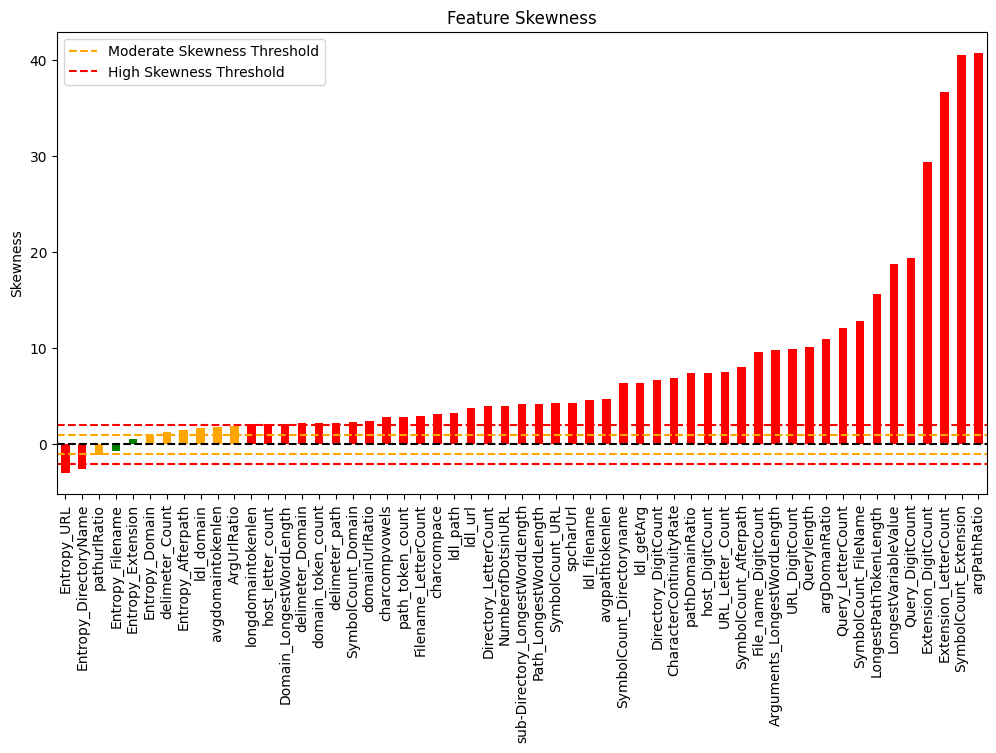

In [11]:
plt.figure(figsize=(12, 6))
sorted_skewness.plot(kind='bar', color=['red' if abs(i) > 2 else 'orange' if abs(i) > 1 else 'green' for i in sorted_skewness])
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=1, color='orange', linestyle='dashed', label='Moderate Skewness Threshold')
plt.axhline(y=-1, color='orange', linestyle='dashed')
plt.axhline(y=2, color='red', linestyle='dashed', label='High Skewness Threshold')
plt.axhline(y=-2, color='red', linestyle='dashed')
plt.legend()
plt.title("Feature Skewness")
plt.ylabel("Skewness")
plt.show()

**Check for missing values**

In [12]:
print("Missing values per column:")
print(final_df.isnull().sum())


Missing values per column:
ArgUrlRatio                           0
Arguments_LongestWordLength           0
CharacterContinuityRate               0
Directory_DigitCount                  0
Directory_LetterCount                 0
Domain_LongestWordLength              0
Entropy_Afterpath                     3
Entropy_DirectoryName              1879
Entropy_Domain                        0
Entropy_Extension                     3
Entropy_Filename                    166
Entropy_URL                           0
Extension_DigitCount                  0
Extension_LetterCount                 0
File_name_DigitCount                  0
Filename_LetterCount                  0
LongestPathTokenLength                0
LongestVariableValue                  0
NumberofDotsinURL                     0
Path_LongestWordLength                0
Query_DigitCount                      0
Query_LetterCount                     0
Querylength                           0
SymbolCount_Afterpath                 0
SymbolCount_D

**filling missing rows**

In [13]:
# Fill NaN values for Highly Skewed Features using median
final_df[highly_skewed.index] = final_df[highly_skewed.index].fillna(final_df[highly_skewed.index].median())

# Fill NaN values for Moderately Skewed Features dynamically
for feature in moderately_skewed.index:
    skew_value = skew(final_df[feature].dropna()) 
    
    if 1 <= abs(skew_value) < 1.5:
        final_df[feature] = final_df[feature].fillna(final_df[feature].mean())
    elif 1.5 <= abs(skew_value) <= 2:
        final_df[feature] = final_df[feature].fillna(final_df[feature].median())

# Fill NaN values for Approximately Normal Features using mean
final_df[approximately_normal.index] = final_df[approximately_normal.index].fillna(final_df[approximately_normal.index].mean())

print("Missing values after imputation:", final_df.isnull().sum().sum())  # Should return 0 if all NaN values are filled


Missing values after imputation: 0


# *Handling Duplicates*

**Check for Duplicates**

In [14]:
# Check how many duplicate rows exist
num_duplicates = final_df.duplicated().sum()
print("Total duplicate rows:", num_duplicates)

if num_duplicates > 0:
    duplicates = final_df[final_df.duplicated()]
    print("Sample duplicate rows:")
    print(duplicates.sample(min(5, num_duplicates)))  


Total duplicate rows: 88867
Sample duplicate rows:
        ArgUrlRatio  Arguments_LongestWordLength  CharacterContinuityRate  \
173746     0.430769                           10                 0.015385   
516978     0.177778                            8                 0.000000   
144532     0.000000                            0                 0.000000   
340252     0.000000                            0                 0.000000   
77214      0.000000                            0                 0.013889   

        Directory_DigitCount  Directory_LetterCount  Domain_LongestWordLength  \
173746                     0                     13                         7   
516978                     0                     31                         0   
144532                     7                     14                         0   
340252                     0                     15                         0   
77214                     10                     29                        10   


**Remove Duplicates**

In [15]:

# Remove duplicates
print("Before removing duplicates:", final_df.shape)
final_df.drop_duplicates(inplace=True)
print("After removing duplicates:", final_df.shape)


Before removing duplicates: (665670, 57)
After removing duplicates: (576803, 57)


In [16]:
final_df

,ArgUrlRatio,Arguments_LongestWordLength,CharacterContinuityRate,Directory_DigitCount,Directory_LetterCount,Domain_LongestWordLength,Entropy_Afterpath,Entropy_DirectoryName,Entropy_Domain,Entropy_Extension,...,ldl_getArg,ldl_path,ldl_url,longdomaintokenlen,pathDomainRatio,path_token_count,pathurlRatio,spcharUrl,sub-Directory_LongestWordLength,tld
0,0.000000,0,0.000000,0,13,0,0.000000,3.375000,0.000000,1.000000,...,0,16,16,0,0.000000,1,1.000000,3,16,
1,0.000000,0,0.000000,1,29,0,0.000000,4.079143,0.000000,2.000000,...,0,35,35,0,0.000000,3,1.000000,4,17,
2,0.000000,0,0.000000,1,25,0,0.000000,3.708093,0.000000,1.584963,...,0,31,31,0,0.000000,4,1.000000,5,14,
3,0.556818,18,0.011364,0,8,14,4.280341,3.121928,3.146286,0.918296,...,49,10,88,14,0.588235,1,0.113636,16,9,be
4,0.825532,161,0.000000,0,8,19,5.360074,3.121928,3.501398,0.918296,...,194,10,235,19,0.434783,1,0.042553,13,9,net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665662,0.192982,0,0.500000,0,15,4,0.947443,0.783307,0.879588,0.931745,...,1,1,1,4,4.000000,7,0.701754,4,8,3
665664,0.047619,-1,0.687500,0,4,10,-1.000000,0.898227,0.843750,1.000000,...,0,1,1,10,1.187500,5,0.452381,3,4,3
665665,0.582192,23,0.500000,4,46,12,0.796205,0.777498,0.791265,0.656684,...,2,3,3,12,4.346154,14,0.773973,6,11,4
665667,0.739837,0,0.772727,6,71,16,0.705245,0.684777,0.801139,0.717187,...,18,20,20,16,9.863636,27,0.882114,12,12,3


# Encode Categorical Variables

In [17]:
# Encode labels only if 'label' column exists
if 'label' in final_df.columns:
    if final_df['label'].dtype == 'object':
        le = LabelEncoder()
        final_df['label_encoded'] = le.fit_transform(final_df['label'])
    else:
        final_df['label_encoded'] = final_df['label']  # Keep as is if already numeric

if 'tld' in final_df.columns:
    # Convert all values in 'tld' column to strings
    final_df['tld'] = final_df['tld'].astype(str)
    
    # Apply Label Encoding
    le = LabelEncoder()
    final_df['tld_encoded'] = le.fit_transform(final_df['tld'])
    
    # Drop original 'tld' column
    final_df.drop(columns=['tld'], inplace=True)

# Ensure 'tld' exists before encoding
if 'tld' in final_df.columns:
    le = LabelEncoder()
    final_df['tld_encoded'] = le.fit_transform(final_df['tld'])
    final_df.drop(columns=['tld'], inplace=True)  # Remove original 'tld' column

final_df.drop(columns=['label'], inplace=True)

**Check if any categorical column left**

In [18]:
non_numeric_cols = final_df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index([], dtype='object')


# *Correlation*

In [19]:
correlation_with_target = final_df.corr()['label_encoded'].sort_values(ascending=False)
print(correlation_with_target )

label_encoded                      1.000000
CharacterContinuityRate            0.440732
domain_token_count                 0.407535
SymbolCount_Domain                 0.386920
domainUrlRatio                     0.369108
host_letter_count                  0.332170
avgdomaintokenlen                  0.316124
longdomaintokenlen                 0.307841
Domain_LongestWordLength           0.300389
tld_encoded                        0.299459
Entropy_Domain                     0.284555
delimeter_Domain                   0.269982
ldl_domain                         0.244365
host_DigitCount                    0.184814
Extension_DigitCount               0.169107
NumberofDotsinURL                  0.167437
SymbolCount_Extension              0.165549
pathDomainRatio                    0.163165
Extension_LetterCount              0.149106
argDomanRatio                      0.126963
Entropy_Extension                  0.080555
path_token_count                   0.071205
Query_LetterCount               

Selected Strong Features: ['label_encoded', 'CharacterContinuityRate', 'domain_token_count', 'SymbolCount_Domain', 'domainUrlRatio', 'host_letter_count', 'avgdomaintokenlen', 'longdomaintokenlen', 'Domain_LongestWordLength', 'ldl_path', 'Directory_LetterCount', 'Entropy_URL', 'Entropy_DirectoryName']


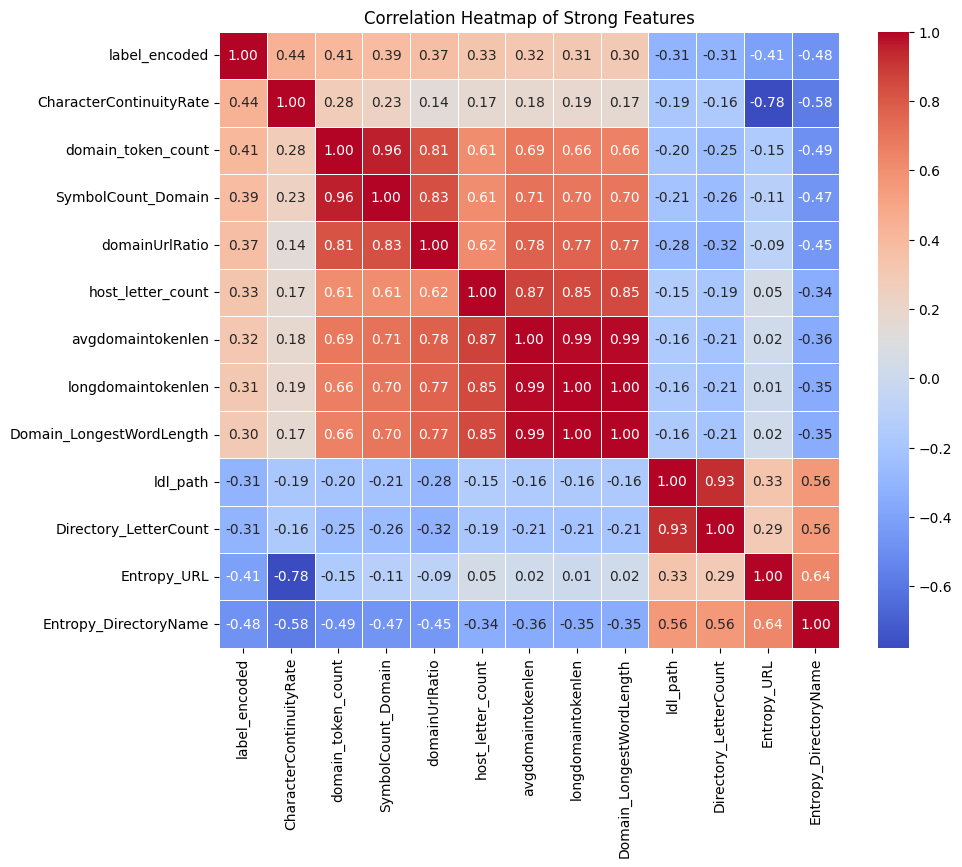

In [20]:
# Define a stricter correlation threshold
correlation_threshold = 0.3 


# Compute correlation with target
correlation_with_target = final_df.corr()['label_encoded'].sort_values(ascending=False)

# Keep only features within the specified correlation range
strong_features = correlation_with_target[
    (abs(correlation_with_target) >= correlation_threshold)
].index

# Filter dataset to retain only strong features
final_df_strong = final_df[strong_features]

# Drop 'label_encoded' from features if keeping it separately for model training
X = final_df_strong.drop(columns=['label_encoded'], errors='ignore')
y = final_df['label_encoded']

# Print the selected features
print("Selected Strong Features:", list(strong_features))


# Compute correlation matrix for strong features
plt.figure(figsize=(10, 8))
sns.heatmap(final_df_strong.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Strong Features")
plt.show()

# *Check Classes Distribution*

Class Distribution Before Balancing:
label_encoded
0    385524
3     84345
1     75644
2     18506
4     12784
Name: count, dtype: int64


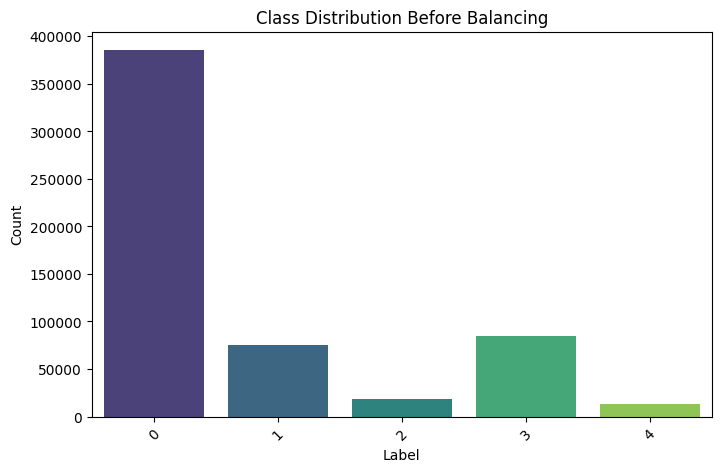

Imbalance Ratio (Max/Min Class Count): 30.16


In [21]:


# Check class distribution
class_counts = final_df_strong['label_encoded'].value_counts()
print("Class Distribution Before Balancing:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Class Distribution Before Balancing")
plt.xticks(rotation=45)
plt.show()

# Calculate class imbalance ratio
min_class = class_counts.min()
max_class = class_counts.max()
imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
print(f"Imbalance Ratio (Max/Min Class Count): {imbalance_ratio:.2f}")


# *Balancing the Dataset*

In [22]:

# Initialize SMOTETomek (SMOTE + Undersampling)
smote_tomek = SMOTETomek(random_state=42)

# Apply SMOTETomek to balance the dataset
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

print("Class Distribution After SMOTE + Undersampling:", Counter(y_resampled))

Class Distribution After SMOTE + Undersampling: Counter({4: 385524, 1: 384616, 2: 383776, 0: 376343, 3: 375589})


Class Distribution After SMOTE + Undersampling: Counter({4: 385524, 1: 384616, 2: 383776, 0: 376343, 3: 375589})
Imbalance Ratio (Max/Min Class Count): 1.03


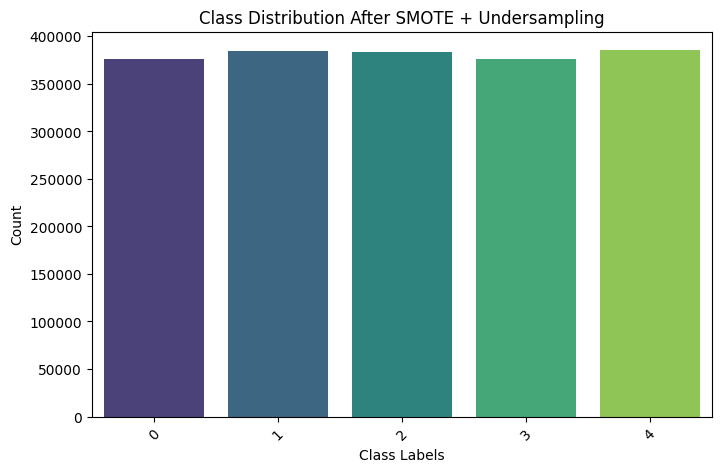

In [23]:
# Get class counts
class_counts = Counter(y_resampled)

# Compute imbalance ratio (max/min class count)
min_class = min(class_counts.values())  # Get the smallest class count
max_class = max(class_counts.values())  # Get the largest class count

imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
print("Class Distribution After SMOTE + Undersampling:", class_counts)
print(f"Imbalance Ratio (Max/Min Class Count): {imbalance_ratio:.2f}")


# Function to plot class distribution
def plot_class_distribution(y, title):
    class_counts = Counter(y)
    classes, counts = zip(*class_counts.items())

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(classes), y=list(counts), palette="viridis")
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


# Plot after resampling
plot_class_distribution(y_resampled, "Class Distribution After SMOTE + Undersampling")

In [ ]:
# Save X (features) to CSV
X_resampled.to_csv("X_features.csv", index=False)

# Save y (labels) to CSV
y_resampled.to_csv("y_labels.csv", index=False)

print("X and y saved as CSV files successfully!")


# *ML Model*

**Train Test Split**

In [33]:
X_resampled = pd.read_csv("/kaggle/input/cleaned/X_features.csv")
y_resampled = pd.read_csv("/kaggle/input/cleaned/y_labels.csv")

# Split data into train and test sets
print(colored("\n Splitting Data into Training and Testing Sets...", "cyan", attrs=["bold"]))
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



 Splitting Data into Training and Testing Sets...


**XgBoost and Random Forest Training**

In [37]:
# Initialize Models
print(colored("\n Initializing Models...", "magenta", attrs=["bold"]))
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, 
                          use_label_encoder=False, eval_metric="mlogloss", tree_method="gpu_hist")



# Train Models
print(colored("\n Training Random Forest (CPU)...", "blue", attrs=["bold"]))
rf_model.fit(X_train, y_train)
print(colored(" Random Forest Training Completed.", "blue", attrs=["bold"]))

print(colored("\n Training XGBoost (GPU)...", "green", attrs=["bold"]))
xgb_model.fit(X_train, y_train)
print(colored(" XGBoost Training Completed (Using GPU).", "green", attrs=["bold"]))



 Initializing Models...

 Training Random Forest (CPU)...
 Random Forest Training Completed.

 Training XGBoost (GPU)...
 XGBoost Training Completed (Using GPU).


**Predictions**

In [38]:

print(colored("\n Making Predictions...", "cyan", attrs=["bold"]))
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)



 Making Predictions...


**Evaluation**

In [39]:

print(colored("\n Random Forest Performance:", "yellow", attrs=["bold"]))
print(colored(classification_report(y_test, y_pred_rf), "yellow"))
print(colored("Confusion Matrix:", "yellow"))
print(colored(confusion_matrix(y_test, y_pred_rf), "yellow"))

print(colored("\n XGBoost Performance (GPU Enabled):", "red", attrs=["bold"]))
print(colored(classification_report(y_test, y_pred_xgb), "red"))
print(colored("Confusion Matrix:", "red"))
print(colored(confusion_matrix(y_test, y_pred_xgb), "red"))




 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     74967
           1       0.98      0.99      0.99     77063
           2       0.99      0.97      0.98     76853
           3       0.90      0.86      0.88     75048
           4       1.00      1.00      1.00     77239

    accuracy                           0.95    381170
   macro avg       0.95      0.95      0.95    381170
weighted avg       0.95      0.95      0.95    381170

Confusion Matrix:
[[69433    71   216  5247     0]
 [   67 76508   128   360     0]
 [  706   121 74393  1633     0]
 [ 7854  1536   748 64910     0]
 [    0     0     0     0 77239]]

 XGBoost Performance (GPU Enabled):
              precision    recall  f1-score   support

           0       0.81      0.90      0.86     74967
           1       0.86      0.96      0.91     77063
           2       0.94      0.87      0.91     76853
           3       0.82      0.69      0.75 

**Feature Importance**


 Plotting Feature Importance for Random Forest...


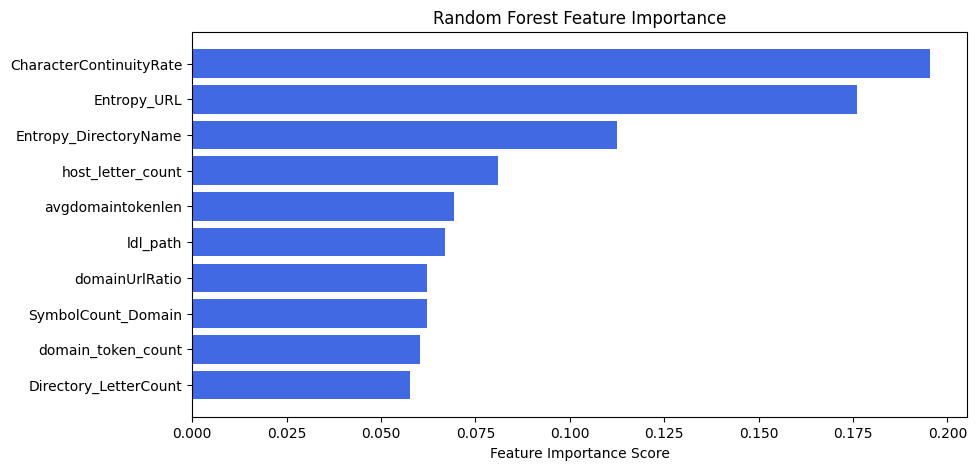


 Plotting Feature Importance for XGBoost (GPU)...


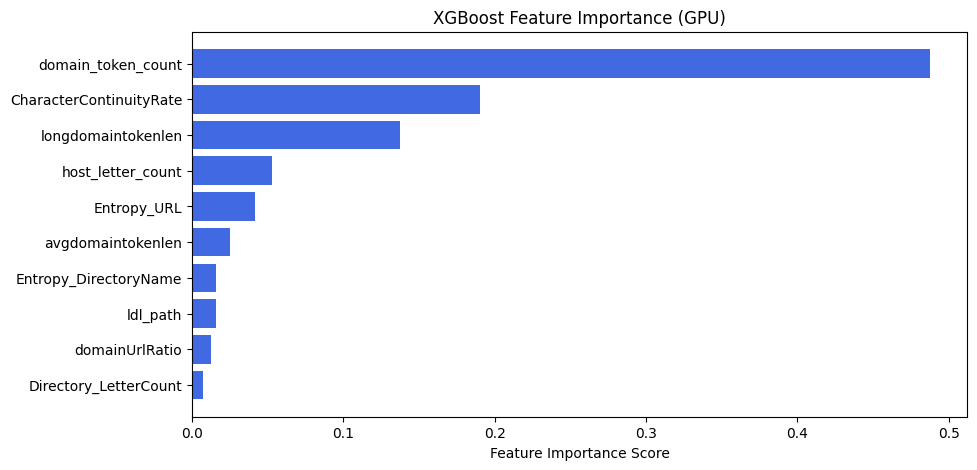


 Model Training & Evaluation Completed Successfully! 


In [40]:
# Feature Importance Plot
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[-10:]  # Get top 10 features
    plt.figure(figsize=(10, 5))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='royalblue')
    plt.xlabel("Feature Importance Score")
    plt.title(title)
    plt.show()

# Plot Feature Importance
print(colored("\n Plotting Feature Importance for Random Forest...", "cyan", attrs=["bold"]))
plot_feature_importance(rf_model, X_resampled.columns, "Random Forest Feature Importance")

print(colored("\n Plotting Feature Importance for XGBoost (GPU)...", "green", attrs=["bold"]))
plot_feature_importance(xgb_model, X_resampled.columns, "XGBoost Feature Importance (GPU)")

print(colored("\n Model Training & Evaluation Completed Successfully! ", "yellow", attrs=["bold"]))

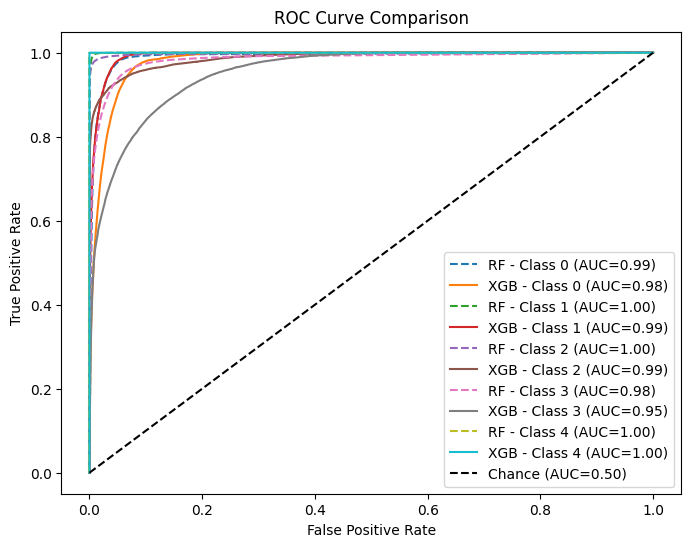

In [41]:

y_prob_rf = rf_model.predict_proba(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

# Compute ROC curve for each class
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(np.unique(y_test))):
    fpr_rf, tpr_rf, _ = roc_curve(y_test == i, y_prob_rf[:, i])
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test == i, y_prob_xgb[:, i])

    plt.plot(fpr_rf, tpr_rf, linestyle="--", label=f"RF - Class {i} (AUC={auc(fpr_rf, tpr_rf):.2f})")
    plt.plot(fpr_xgb, tpr_xgb, linestyle="-", label=f"XGB - Class {i} (AUC={auc(fpr_xgb, tpr_xgb):.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC=0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# **LSTM**

In [35]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).squeeze()
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).squeeze()

print(f"Shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"LSTM Shapes - X_train_tensor: {X_train_tensor.shape}, X_test_tensor: {X_test_tensor.shape}")

batch_size = 32
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),  
    batch_size=batch_size, 
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), 
    batch_size=batch_size, 
    shuffle=False
)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_size=128, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_size, 
            num_layers=num_layers, 
            dropout=dropout, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, len(y_train_tensor.unique()))  

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  
        return out

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=X_train_scaled.shape[1]).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Early Stopping Setup
patience = 3  
best_val_loss = float('inf')
epochs_no_improve = 0  

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}", leave=True) as pbar:
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"}, refresh=False)

    scheduler.step()
    
    # Validation phase
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
            correct += (torch.argmax(outputs, dim=1) == y_batch).sum().item()
            total += y_batch.size(0)
    
    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    
    print(
        f"\nEpoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}\n"
    )
    
    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0 
    else:
        epochs_no_improve += 1
        print(f"Early stopping patience: {epochs_no_improve}/{patience}")
    
    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}!")
        break  

print("\nTraining Complete!")


Shapes - X_train: (1524678, 12), X_test: (381170, 12)
LSTM Shapes - X_train_tensor: torch.Size([1524678, 1, 12]), X_test_tensor: torch.Size([381170, 1, 12])


Epoch 1/10: 100%|██████████| 47647/47647 [02:26<00:00, 325.24batch/s, batch_loss=0.2376]



Epoch 1/10 | Train Loss: 0.3699 | Val Loss: 0.3061 | Val Acc: 0.8779



Epoch 2/10: 100%|██████████| 47647/47647 [02:25<00:00, 328.04batch/s, batch_loss=0.3328]



Epoch 2/10 | Train Loss: 0.3069 | Val Loss: 0.2824 | Val Acc: 0.8862



Epoch 3/10: 100%|██████████| 47647/47647 [02:25<00:00, 327.45batch/s, batch_loss=0.0932]



Epoch 3/10 | Train Loss: 0.2874 | Val Loss: 0.2622 | Val Acc: 0.8946



Epoch 4/10: 100%|██████████| 47647/47647 [02:25<00:00, 327.95batch/s, batch_loss=0.0654]



Epoch 4/10 | Train Loss: 0.2774 | Val Loss: 0.2526 | Val Acc: 0.8979



Epoch 5/10: 100%|██████████| 47647/47647 [02:25<00:00, 328.57batch/s, batch_loss=0.5369]



Epoch 5/10 | Train Loss: 0.2700 | Val Loss: 0.2448 | Val Acc: 0.9004



Epoch 6/10: 100%|██████████| 47647/47647 [02:24<00:00, 328.65batch/s, batch_loss=0.0688]



Epoch 6/10 | Train Loss: 0.2575 | Val Loss: 0.2393 | Val Acc: 0.9025



Epoch 7/10: 100%|██████████| 47647/47647 [02:25<00:00, 327.70batch/s, batch_loss=0.5686]



Epoch 7/10 | Train Loss: 0.2546 | Val Loss: 0.2327 | Val Acc: 0.9047



Epoch 8/10: 100%|██████████| 47647/47647 [02:25<00:00, 328.45batch/s, batch_loss=0.0120]



Epoch 8/10 | Train Loss: 0.2523 | Val Loss: 0.2325 | Val Acc: 0.9049



Epoch 9/10: 100%|██████████| 47647/47647 [02:25<00:00, 328.46batch/s, batch_loss=0.0920]



Epoch 9/10 | Train Loss: 0.2503 | Val Loss: 0.2303 | Val Acc: 0.9054



Epoch 10/10: 100%|██████████| 47647/47647 [02:25<00:00, 328.32batch/s, batch_loss=0.1151]



Epoch 10/10 | Train Loss: 0.2490 | Val Loss: 0.2277 | Val Acc: 0.9067


Training Complete!


**Evaluation and ROC----LsTm**

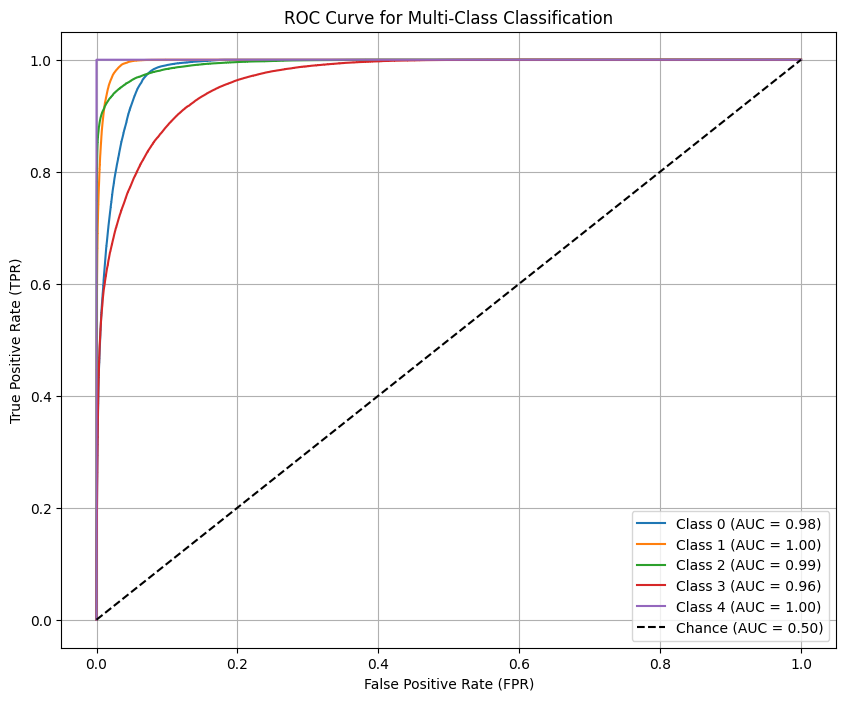

Overall AUC Score: 0.9881


In [36]:

model.eval()
y_probs = []
y_true = [] 

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)  
        y_probs.append(probs.cpu().numpy())
        y_true.append(y_batch.cpu().numpy())

# Convert lists to numpy arrays
y_probs = np.vstack(y_probs)
y_true = np.concatenate(y_true)

# Compute ROC curve for each class
n_classes = y_probs.shape[1]
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

# Formatting the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Overall AUC Score: {roc_auc_score(y_true, y_probs, multi_class='ovr'):.4f}")


# *F1 Score Comparison of XgBoost, RF, LSTM*

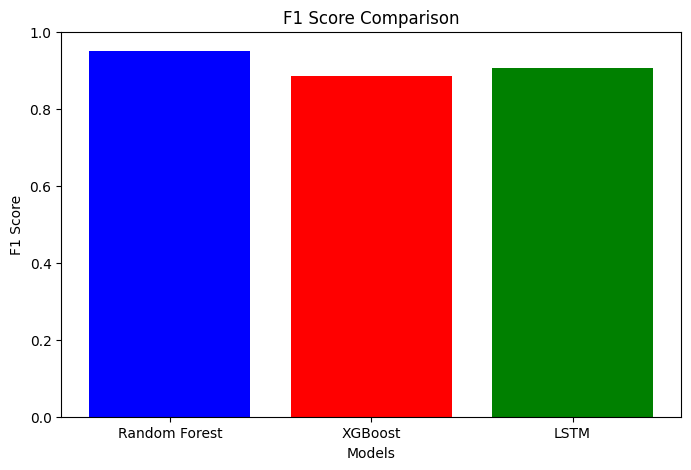

In [42]:
# Convert LSTM probabilities to predicted class labels
y_pred_lstm = np.argmax(y_probs, axis=1) 


f1_rf = f1_score(y_true, y_pred_rf, average="weighted")
f1_xgb = f1_score(y_true, y_pred_xgb, average="weighted")
f1_lstm = f1_score(y_true, y_pred_lstm, average="weighted")

models = ["Random Forest", "XGBoost", "LSTM"]
f1_scores = [f1_rf, f1_xgb, f1_lstm]

plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color=["blue", "red", "green"])
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.ylim(0, 1)  
plt.show()


Thankyou